In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold

In [2]:
%matplotlib inline

In [3]:
def getProcessedDataFrame(filepath):
    dataset = arff.loadarff(filepath)
    df = pd.DataFrame(dataset[0])
    str_df = df.select_dtypes([np.object]) 
    str_df = str_df.stack().str.decode('utf-8').unstack()

    for col in str_df.columns:
        str_df[col] = str_df[col].astype(int)
    return str_df

In [4]:
complete_training = getProcessedDataFrame("Training Dataset.arff")
print(complete_training.columns)

#We will not include: SSLfinal_State,Domain_registration_length,port,Abnormal_URL,Redirect,popUpWindow,Google_Index,Links_pointing_to_page,Statistical_report
reduced_df = complete_training[['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain','Favicon', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email','on_mouseover', 'RightClick', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank','Result']]

<ipython-input-3-f318a902d841>:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_df = df.select_dtypes([np.object])


Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')


In [5]:
complete_training['Result'].value_counts()

 1    6157
-1    4898
Name: Result, dtype: int64

## Metrics to evaluate this Project:

Because the data we have is balanced (around 55:45%) we will consider ACCURACY as our major metric. We will also have to ensure that we will have a minimal TYPE ONE error (Minimize false positives)(FPR). 
This is because it is important that the user does not enter an unsafe url. We can tradeoff classifying a safe url as unsafe for the same reason as well.

In [6]:
#We encode the data into positive values as our algorithms work better then
def convertEncodingToPositive(dataframe):

    mapping = {-1: 2, 0: 0, 1: 1}

    col_map = {}

    for col in dataframe:
        col_map[col] = mapping

    for i in range(dataframe.shape[0]):
        for j in range(dataframe.shape[1]):
            dataframe.loc[i][j] = mapping[dataframe.loc[i][j]]

In [7]:
convertEncodingToPositive(reduced_df)
reduced_df

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Favicon,HTTPS_token,Request_URL,...,SFH,Submitting_to_email,on_mouseover,RightClick,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Result
0,2,1,1,1,2,2,2,1,2,1,...,2,2,1,1,1,2,2,2,2,2
1,1,1,1,1,1,2,0,1,2,1,...,2,1,1,1,1,2,2,0,2,2
2,1,0,1,1,1,2,2,1,2,1,...,2,2,1,1,1,1,2,1,2,2
3,1,0,1,1,1,2,2,1,2,2,...,2,1,1,1,1,2,2,1,2,2
4,1,0,2,1,1,2,1,1,1,1,...,2,1,2,1,1,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,2,1,2,1,1,1,2,1,1,...,2,2,2,2,2,1,1,2,2,1
11051,2,1,1,2,2,2,1,2,1,1,...,0,2,2,1,1,1,1,1,1,2
11052,1,2,1,1,1,2,1,1,1,1,...,2,1,1,1,1,1,1,1,2,2
11053,2,2,1,1,1,2,2,2,1,2,...,2,1,2,1,1,1,1,1,2,2


In [8]:
X_reduced = reduced_df.iloc[:,0:21]
y_reduced = reduced_df.iloc[:, -1]

In [9]:
#Splits data into training and test data
#Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=7, stratify=y_reduced)

print(type(X_train_red))
print(X_train_red.shape)
print(X_test_red.shape)
print(y_train_red.shape)
print(y_test_red.shape,"\n")
X_train_red = X_train_red.to_numpy()
X_test_red = X_test_red.to_numpy()
y_train_red = y_train_red.to_numpy()
y_test_red = y_test_red.to_numpy()

print(type(X_train_red))
print(X_train_red.shape)
print(X_test_red.shape)
print(y_train_red.shape)
print(y_test_red.shape)

<class 'pandas.core.frame.DataFrame'>
(8844, 21)
(2211, 21)
(8844,)
(2211,) 

<class 'numpy.ndarray'>
(8844, 21)
(2211, 21)
(8844,)
(2211,)


In [10]:
#From the training and test data, we will have a 5fold spilt for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=786)

In [11]:
for train, test in kf.split(X_train_red):
    print(X_train_red[train].shape, y_train_red[train].shape, X_train_red[test].shape, y_train_red[test].shape)

(7075, 21) (7075,) (1769, 21) (1769,)
(7075, 21) (7075,) (1769, 21) (1769,)
(7075, 21) (7075,) (1769, 21) (1769,)
(7075, 21) (7075,) (1769, 21) (1769,)
(7076, 21) (7076,) (1768, 21) (1768,)


In [12]:
#Confusion matrix assesses the performance of a classification model (F score types) (Precision and recall)
from sklearn.metrics import confusion_matrix

In [13]:
def plot_cm(y_val, y_pred):
    labels = [1, 0]
    cm = confusion_matrix(y_val, y_pred, labels)
    # print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
#tp=true positive, fn=false negative, fp=false positive, tn=true negative

In [14]:
import pickle
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
X_train_red_onehot = encoder.fit_transform(X_train_red)
X_test_red_onehot = encoder.transform(X_test_red)
pickle.dump(encoder, open("One_Hot_Encoder", 'wb'))

## Categorical Naive Bayes

In [15]:
from sklearn import metrics
from pprint import pprint
from sklearn.naive_bayes import CategoricalNB

In [16]:
def to_use_GNB(X_train_red, y_train_red):
    
    #These will store values for the accuracy scores
    accuracy_scores_catNB = []
    
    #Do this for all n splits
    for train, val in kf.split(X_train_red):
        
        clf_NB = CategoricalNB()
        
        #Train Model
        clf_NB = clf_NB.fit(X_train_red[train], y_train_red[train])
        
        #Using validation data to predict
        predictions = clf_NB.predict(X_train_red[val])
        tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val], predictions).ravel()
        accuracy = (tn+tp)/(fp+fn+tp+tn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*precision*recall/(precision + recall)
        accuracy_scores_catNB.append((accuracy, precision, recall, fpr, f1))

    return np.mean(accuracy_scores_catNB, axis=0)

metric_GNB = to_use_GNB(X_train_red_onehot, y_train_red)
print(metric_GNB)

[0.88184073 0.88245769 0.90887024 0.15205115 0.89545162]


## K-Nearest Neighbours

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
def gridsearch_KNN(X_train_red_onehot, y_train_red):
    clf_knn = KNeighborsClassifier()
    knn_param_grid = {
      "n_neighbors": [3, 5, 7, 9, 15],
      "metric": ['euclidean', 'manhattan']
    }

    gs_knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv = 3)
    gs_results = gs_knn.fit(X_train_red_onehot, y_train_red)

    return gs_results.best_params_

bestparams_knn = gridsearch_KNN(X_train_red_onehot, y_train_red)
print(bestparams_knn)

{'metric': 'euclidean', 'n_neighbors': 3}


In [19]:
def to_use_KNN(X_train_red, y_train_red):
    accuracy_scores_catKNN = []
    for train, val in kf.split(X_train_red):
        
        clf_neigh = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
        
        #Train model
        clf_neigh = clf_neigh.fit(X_train_red[train], y_train_red[train])
        
        #Make predictions
        predictions = clf_neigh.predict(X_train_red[val])
        tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val], predictions).ravel()
        accuracy = (tn+tp)/(fp+fn+tp+tn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*precision*recall/(precision + recall)
        accuracy_scores_catKNN.append((accuracy, precision, recall, fpr, f1))
  
    return np.mean(accuracy_scores_catKNN, axis=0)

metric_KNN = to_use_KNN(X_train_red_onehot, y_train_red)
print(metric_KNN)

[0.92311158 0.93480098 0.9266088  0.0815385  0.93062615]


## XGBoost

In [20]:
#!pip install xgboost
from xgboost import XGBClassifier

In [21]:
def to_use_XGB(X_train_red, y_train_red):
    accuracy_scores_xgb = []
    for train, val in kf.split(X_train_red):
        
        
        clf_xgb = XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.01,  
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic', 
                        n_estimators=1000, 
                        reg_alpha = 0.3,
                        max_depth=4, 
                        gamma=10)
        
        #Train Model
        clf_xgb = clf_xgb.fit(X_train_red[train], y_train_red[train])
        
        #Predict
        predictions = clf_xgb.predict(X_train_red[val])
        
        tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val], predictions).ravel()
        accuracy = (tn+tp)/(fp+fn+tp+tn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*precision*recall/(precision + recall)
        accuracy_scores_xgb.append((accuracy, precision, recall, fpr, f1))

    return np.mean(accuracy_scores_xgb, axis=0)
    
metric_xgb = to_use_XGB(X_train_red_onehot, y_train_red)
print(metric_xgb)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.90422862 0.89179936 0.94229129 0.14369149 0.9163316 ]


## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
def grid_search_decision_tree(X_train_red, y_train_red):
    dt = DecisionTreeClassifier(random_state=5)
    p = {"max_depth": range(1,20), "random_state":[5]}
    gs = GridSearchCV(estimator=dt,param_grid=p)
    gs_fit = gs.fit(X_train_red, y_train_red)
    return gs_fit.best_params_

best_params_decision_tree = grid_search_decision_tree(X_train_red_onehot, y_train_red)
print(best_params_decision_tree)

{'max_depth': 18, 'random_state': 5}


In [24]:
def to_use_decisiontree(X_train_red, y_train_red):
    accuracy_scores_dt = []
    for train, val in kf.split(X_train_red):
        dt = DecisionTreeClassifier(random_state=5, max_depth=18)
        dt = dt.fit(X_train_red[train], y_train_red[train])
        tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val],dt.predict(X_train_red[val])).ravel()
        dt_accuracy = (tn+tp)/(tp+tn+fp+fn)
        dt_prec = tp/(tp+fp)
        dt_rec = tp/(tp+fn)
        dt_fpr = fp/(fp+tn)
        dt_f1 = 2*dt_prec*dt_rec/(dt_prec+dt_rec)
        accuracy_scores_dt.append((dt_accuracy,dt_prec,dt_rec,dt_fpr,dt_f1))
  
    return np.mean(accuracy_scores_dt,axis=0)

metric_decision_tree = to_use_decisiontree(X_train_red_onehot, y_train_red)
print(metric_decision_tree)

[0.92899157 0.92864118 0.94521799 0.0914861  0.93684338]


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
def grid_search_random_forest(X_train_red_onehot, y_train_red):
    rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
    param_grid = { 
      'n_estimators': [200, 700],
      'max_features': ['auto', 'sqrt', 'log2']
    }
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train_red, y_train_red)
    return CV_rfc.best_params_

best_params_rfc = grid_search_random_forest(X_train_red_onehot, y_train_red)
print(best_params_rfc)

{'max_features': 'log2', 'n_estimators': 200}


In [27]:
def to_use_rfc(X_train_red_onehot, y_train_red):
    accuracy_scores_forest = []
    for train, val in kf.split(X_train_red):
        rforest = RandomForestClassifier(max_features= 'auto' ,n_estimators=200)
        rforest = rforest.fit(X_train_red_onehot[train],y_train_red[train])
        tp1, fn1, fp1, tn1 = metrics.confusion_matrix(y_train_red[val],rforest.predict(X_train_red_onehot[val])).ravel()
        r_accuracy = (tn1 + tp1)/(tn1+tp1+fn1+fp1)
        r_prec = tp1/(tp1+fp1)
        r_rec = tp1/(tp1+fn1)
        r_fpr = fp1/(fp1+tn1)
        r_f1 = 2*(r_prec)*r_rec/(r_prec+r_rec)
        accuracy_scores_forest.append((r_accuracy,r_prec,r_rec,r_fpr,r_f1))

    return np.mean(accuracy_scores_forest, axis=0)
  

metric_rforest = to_use_rfc(X_train_red_onehot, y_train_red)
print(metric_rforest)

[0.93543608 0.93616181 0.94886084 0.08145889 0.94243333]


## Support Vector Machines

In [28]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [29]:
def grid_search_svm(X_train_red_onehot, y_train_red):
    svm_clf = svm.SVC()
    param_grid = {'C': [0.1, 1, 10, 100],  
                'gamma': [1, 0.1, 0.01, 0.001], 
                'kernel': ['rbf', 'linear']}  

    gs_svm = GridSearchCV(svm.SVC(), param_grid, cv = 3)
    gs_results = gs_svm.fit(X_train_red_onehot, y_train_red)

    return gs_results.best_params_

bestparams_svm = grid_search_svm(X_train_red_onehot, y_train_red)
print(bestparams_svm)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-13-aff18d0f099d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-13-aff18d0f099d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-13-aff18d0f099d>:10: UserWarning: FixedFormatter shou

[0.93340097 0.93634125 0.94473776 0.08100019 0.94047216]


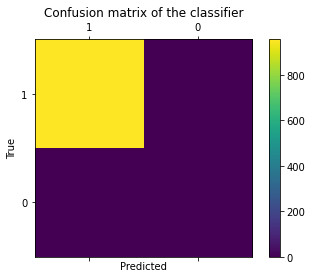

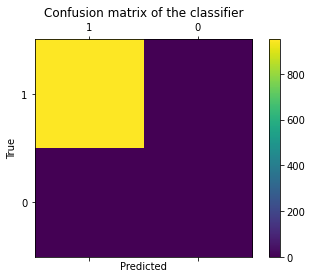

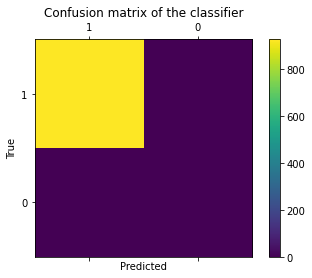

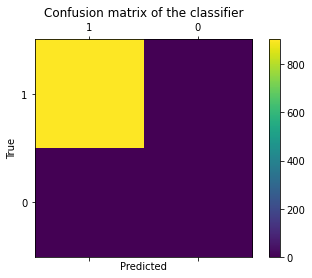

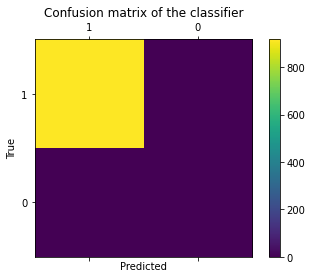

In [30]:
def to_use_SVM(X_train_red_onehot, y_train_red):
    accuracy_scores_svm = []
    for train, val in kf.split(X_train_red_onehot):
        svm_clf = svm.SVC(kernel='rbf', gamma = 0.1, C = 10, probability=True)
        svm_clf = svm_clf.fit(X_train_red_onehot[train], y_train_red[train])
        tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val], svm_clf.predict(X_train_red_onehot[val])).ravel()
        plot_cm(y_train_red[val], svm_clf.predict(X_train_red_onehot[val]))
    
        accuracy = (tn+tp)/(fp+fn+tp+tn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*precision*recall/(precision + recall)
        accuracy_scores_svm.append((accuracy, precision, recall, fpr, f1))


    return np.mean(accuracy_scores_svm, axis=0)

metric_svm = to_use_SVM(X_train_red_onehot, y_train_red)
print(metric_svm)


In [31]:
print("\t===============================================Training Metrics===============================================\n")
labels = ["Accuracy: ", "Precision: ", "Recall: ", "FPR: ", "F1: "]

print("Naive Bayes\n")
for i in range(len(metric_GNB)):
    print(labels[i],metric_GNB[i])

print("\n")

print("KNN\n")
for i in range(len(metric_KNN)):
    print(labels[i],metric_KNN[i])
    
print("\n")

print("XGBoost\n")
for i in range(len(metric_xgb)):
    print(labels[i],metric_xgb[i])
    
print("\n")

print("Decision Trees\n")
for i in range(len(metric_decision_tree)):
    print(labels[i],metric_decision_tree[i])
    
print("\n")

print("Random Forest\n")
for i in range(len(metric_rforest)):
    print(labels[i],metric_rforest[i])
    
print("\n")

print("Support Vector Machines\n")
for i in range(len(metric_svm)):
    print(labels[i],metric_svm[i])

	===============================================Training Metrics===============================================

Naive Bayes

Accuracy:  0.8818407260282033
Precision:  0.8824576876234269
Recall:  0.9088702377016423
FPR:  0.15205114815449808
F1:  0.8954516247351556


KNN

Accuracy:  0.9231115823291528
Precision:  0.9348009791671361
Recall:  0.9266088001416654
FPR:  0.08153850333933772
F1:  0.9306261533110162


XGBoost

Accuracy:  0.9042286206129189
Precision:  0.8917993551367107
Recall:  0.9422912933254924
FPR:  0.14369148642383045
F1:  0.9163315967801408


Decision Trees

Accuracy:  0.9289915692328155
Precision:  0.9286411836359557
Recall:  0.9452179881297237
FPR:  0.09148610070507192
F1:  0.9368433818203528


Random Forest

Accuracy:  0.9354360798978896
Precision:  0.9361618091252281
Recall:  0.948860843905997
FPR:  0.08145888780623634
F1:  0.9424333284357633


Support Vector Machines

Accuracy:  0.9334009679011841
Precision:  0.9363412458980864
Recall:  0.9447377564857872
FPR:  0.081

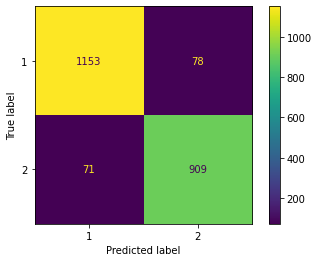

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


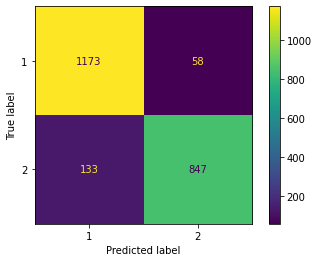

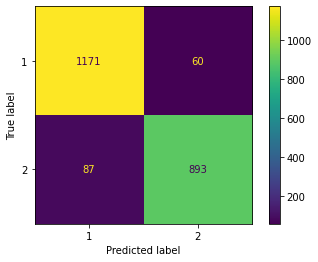

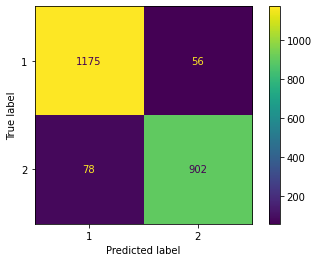

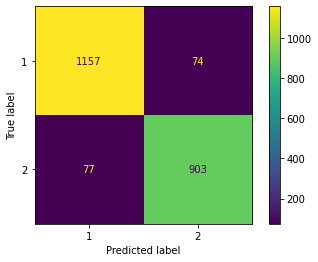

	==============================================Testing Metrics==================================================

KNN: 
 [(0.9326096788783356, 0.9419934640522876, 0.9366368805848904, 0.07244897959183673, 0.9393075356415478)]
XGBoost: 
 [(0.9136137494346449, 0.8981623277182236, 0.9528838342810723, 0.1357142857142857, 0.9247142294048087)]
Decision Tree: 
 [(0.9335142469470827, 0.9308426073131956, 0.9512591389114541, 0.08877551020408163, 0.9409401366010446)]
Random Forest: 
 [(0.9393939393939394, 0.9377494014365523, 0.9545085296506904, 0.07959183673469387, 0.9460547504025765)]
Support Vector Machines: 
 [(0.9317051108095884, 0.9376012965964343, 0.9398862713241267, 0.07857142857142857, 0.9387423935091277)]


In [32]:
from sklearn.metrics import plot_confusion_matrix


def to_test_KNN(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
    accuracy_scores_catKNN = []
        
    clf_neigh = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

    #Train model
    clf_neigh = clf_neigh.fit(X_train_red_onehot, y_train_red)

    #Make predictions
    predictions = clf_neigh.predict(X_test_red_onehot)
    tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, predictions).ravel()
    accuracy = (tn+tp)/(fp+fn+tp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f1 = 2*precision*recall/(precision + recall)
    accuracy_scores_catKNN.append((accuracy, precision, recall, fpr, f1))
    
    plot_confusion_matrix(clf_neigh , X_test_red_onehot, y_test_red)
    plt.show()

    return accuracy_scores_catKNN

test_accuracy_knn = to_test_KNN(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)


def to_test_XGB(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
    accuracy_scores_xgb = []
    clf_xgb = XGBClassifier(silent=False, scale_pos_weight=1,learning_rate=0.01, colsample_bytree = 0.4,subsample = 0.8, objective='binary:logistic',  n_estimators=1000, reg_alpha = 0.3,max_depth=4, gamma=10)

    #Train Model
    clf_xgb = clf_xgb.fit(X_train_red_onehot, y_train_red)


    tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, clf_xgb.predict(X_test_red_onehot)).ravel()
    accuracy = (tn+tp)/(fp+fn+tp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f1 = 2*precision*recall/(precision + recall)
    accuracy_scores_xgb.append((accuracy, precision, recall, fpr, f1))
    plot_confusion_matrix(clf_xgb , X_test_red_onehot, y_test_red)
    plt.show()

    return accuracy_scores_xgb 

test_accuracy_xgb = to_test_XGB(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)

def to_test_decisiontree(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
    accuracy_scores_dt = []
    dt = DecisionTreeClassifier(random_state=5, max_depth=18)
    dt = dt.fit(X_train_red_onehot, y_train_red)
    tp, fn, fp, tn = metrics.confusion_matrix(y_test_red,dt.predict(X_test_red_onehot)).ravel()
    dt_accuracy = (tn+tp)/(tp+tn+fp+fn)
    dt_prec = tp/(tp+fp)
    dt_rec = tp/(tp+fn)
    dt_fpr = fp/(fp+tn)
    dt_f1 = 2*dt_prec*dt_rec/(dt_prec+dt_rec)
    accuracy_scores_dt.append((dt_accuracy,dt_prec,dt_rec,dt_fpr,dt_f1))
    plot_confusion_matrix(dt, X_test_red_onehot, y_test_red)
    plt.show()
  
    return accuracy_scores_dt

test_accuracy_dt = to_test_decisiontree(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)

def to_test_rfc(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
    
    accuracy_scores_rfc = []
    rforest = RandomForestClassifier(max_features= 'sqrt' ,n_estimators=200)
    rforest = rforest.fit(X_train_red_onehot,y_train_red)
    tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, rforest.predict(X_test_red_onehot)).ravel()
    accuracy = (tn+tp)/(fp+fn+tp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f1 = 2*precision*recall/(precision + recall)
    accuracy_scores_rfc.append((accuracy, precision, recall, fpr, f1))
    pickle.dump(rforest, open("RF_Final_Model.pkl", 'wb'))
    plot_confusion_matrix(rforest , X_test_red_onehot, y_test_red)
    plt.show()
    
    return accuracy_scores_rfc
  

test_accuracy_rfc = to_test_rfc(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)


def to_test_SVM(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
    accuracy_scores_svm = []
    svm_clf = svm.SVC(kernel='rbf', gamma = 0.1, C = 10, probability=True)
    svm_clf = svm_clf.fit(X_train_red_onehot, y_train_red)
    tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, svm_clf.predict(X_test_red_onehot)).ravel()
    accuracy = (tn+tp)/(fp+fn+tp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f1 = 2*precision*recall/(precision + recall)
    pickle.dump(svm_clf, open("SVM_Final_Model.pkl", 'wb'))
    accuracy_scores_svm.append((accuracy, precision, recall, fpr, f1))
    plot_confusion_matrix(svm_clf , X_test_red_onehot, y_test_red)
    plt.show()
    
    return accuracy_scores_svm

test_accuracy_svm = to_test_SVM(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)


print("\t==============================================Testing Metrics==================================================\n")

print("KNN: \n",test_accuracy_knn)

print("XGBoost: \n",test_accuracy_xgb)

print("Decision Tree: \n",test_accuracy_dt)

print("Random Forest: \n",test_accuracy_rfc)

print("Support Vector Machines: \n",test_accuracy_svm)

In [36]:
filename_dt = 'SVM_Final_Model.pkl'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_train_red, loaded_model.predict(X_train_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print("Accuracy:",accuracy)
print("Recall:",recall)
print("FPR:",fpr,"\n")

filename_dt = 'SVM_Final_Model.pkl'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, loaded_model.predict(X_test_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print("Accuracy:",accuracy)
print("Recall:",recall)
print("FPR:",fpr,"\n")

print("")

filename_dt = 'RF_Final_Model.pkl'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_train_red, loaded_model.predict(X_train_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print("Accuracy:",accuracy)
print("Recall:",recall)
print("FPR:",fpr,"\n")

filename_dt = 'RF_Final_Model.pkl'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, loaded_model.predict(X_test_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print("Accuracy:",accuracy)
print("Recall:",recall)
print("FPR:",fpr,"\n")

print("Random Forest performs best with least no of false positives and high accuracy and recall, hence we will go forward with this algorithm")


Accuracy: 0.9531886024423338
Recall: 0.9573690621193667
FPR: 0.05206738131699847 

Accuracy: 0.9317051108095884
Recall: 0.9398862713241267
FPR: 0.07857142857142857 


Accuracy: 0.9632519222071461
Recall: 0.9665042630937881
FPR: 0.0408371618172537 

Accuracy: 0.9393939393939394
Recall: 0.9545085296506904
FPR: 0.07959183673469387 

Random Forest performs best with least no of false positives and high accuracy and recall, hence we will go forward with this algorithm


In [34]:
# from sklearn.manifold import TSNE

# def tsne_analysis():
#     """ For TSNE analysis on the training dataset with 
#     last hidden layer output"""

#     filename_dt = 'RF_Final_Model'
#     loaded_model = pickle.load(open(filename_dt, 'rb'))
  
#     hidden_opt = loaded_model.predict_proba(X_train_red_onehot)
#     df = pd.DataFrame(hidden_opt)
#     df['y'] = y_train_red
#     df['label'] = df['y'].apply(lambda i: str(i))
#     tsne = TSNE(n_components = 2, perplexity = 50, verbose = 1, n_iter = 1000)
#     tsne_res = tsne.fit_transform(hidden_opt)

#     df['TSNE 1st component'] = tsne_res[:,0]
#     df['TSNE 2nd component'] = tsne_res[:,1]

#     sns.scatterplot(
#         x = "TSNE 1st component", y = "TSNE 2nd component",
#         hue = 'y',
#         palette = sns.color_palette("hls", 2),
#         data = df,
#         legend = "full",
#         alpha = 0.3
#     )
#     plt.show()

# tsne_analysis()